In [1]:
import numpy as np
import pandas as pd
import re as re
import time
from sklearn.preprocessing import LabelEncoder

# Visualization
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

# Configure Visualization Defaults
%matplotlib inline
pylab.rcParams['figure.figsize'] = 12,8

In [2]:
df_train = pd.read_csv('titanic_data/titanic_train.csv')
df_test = pd.read_csv('titanic_data/titanic_test.csv')
df_full = [df_train, df_test]

In [3]:
# Impute missing values

for dataset in df_full:
    dataset['Age'].fillna(dataset['Age'].median(), inplace=True)
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace=True)

In [4]:
# Feature engineering

# Family size
for dataset in df_full:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch']

# Travelled alone
for dataset in df_full:
    dataset['TrAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 0, 'TrAlone'] = 1

# Passenger title
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, return it, if not return NA
    if title_search:
        return title_search.group(1)
    return "NA"

for dataset in df_full:
    dataset['Title'] = dataset['Name'].apply(get_title)

for dataset in df_full:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir',\
                                                 'Jonkheer', 'Dona', 'Ms', 'Mlle', 'Mme'], 'Other')

In [5]:
# Getting dummy variables
df_train_dummy = pd.get_dummies(df_train[['Sex','Embarked','Title']])
df_test_dummy  = pd.get_dummies(df_test[['Sex','Embarked','Title']])

# Mapping non-numeric attributes
sex_mapping = {'female': 0, 'male': 1}
title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Other': 5}
embarked_mapping = {'S': 0, 'C': 1, 'Q': 2}
for dataset in df_full:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping).astype(int)
    dataset['Title'] = dataset['Title'].map(title_mapping).astype(int)
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping).astype(int)

# Binning continues attributes
label = LabelEncoder()
for dataset in df_full:
    dataset['AgeBin'] = label.fit_transform(pd.cut(dataset['Age'].astype(int),5))
    dataset['FareBin'] = label.fit_transform(pd.qcut(dataset['Fare'], 4))
    dataset['FamilySizeBin'] = label.fit_transform(pd.cut(dataset['FamilySize'].astype(int),5))

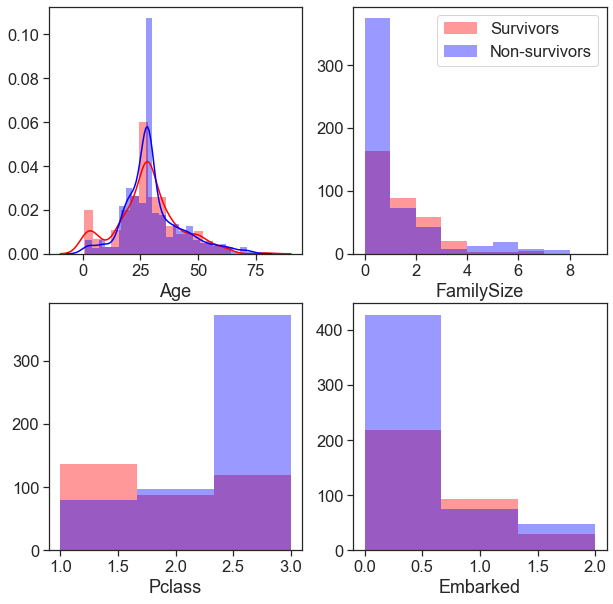

In [6]:
# Make distribution plots
sns.set(font_scale=1.5)
sns.set_style('white')
sns.set_style('ticks')

f = plt.figure(figsize=(10, 10))
gs = f.add_gridspec(2, 2)
# age
ax = f.add_subplot(gs[0, 0])
sns.distplot( df_train[df_train['Survived']==1]['Age'], color='red',\
             hist_kws=dict(edgecolor='none'), label='Survivors')
sns.distplot( df_train[df_train['Survived']==0]['Age'], color='blue',\
             hist_kws=dict(edgecolor='none'), label='Non-survivors')
# familysize
ax = f.add_subplot(gs[0, 1])
sns.distplot(df_train[df_train['Survived']==1]['FamilySize'], color='red',\
             hist_kws=dict(edgecolor='none'), kde=False, bins=range(df_train['FamilySize'].max()), label='Survivors')
sns.distplot(df_train[df_train['Survived']==0]['FamilySize'], color='blue',\
             hist_kws=dict(edgecolor='none'), kde=False, bins=range(df_train['FamilySize'].max()), label='Non-survivors')
plt.legend()
# pclass
ax = f.add_subplot(gs[1, 0])
sns.distplot( df_train[df_train['Survived']==1]['Pclass'], color='red',\
             hist_kws=dict(edgecolor='none'), kde=False, bins=3, label='Survivors')
sns.distplot( df_train[df_train['Survived']==0]['Pclass'], color='blue',\
             hist_kws=dict(edgecolor='none'), kde=False, bins=3, label='Non-survivors')
# embarked
ax = f.add_subplot(gs[1, 1])
sns.distplot(df_train[df_train['Survived']==1]['Embarked'], color='red',\
             hist_kws=dict(edgecolor='none'), kde=False, bins=3, label='Survived')
sns.distplot(df_train[df_train['Survived']==0]['Embarked'], color='blue',\
             hist_kws=dict(edgecolor='none'), kde=False, bins=3, label='Died')
plt.savefig('titanic_stats1.png',format='png')

In [7]:
df_train_dummy.info()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Sex_female    891 non-null    uint8
 1   Sex_male      891 non-null    uint8
 2   Embarked_C    891 non-null    uint8
 3   Embarked_Q    891 non-null    uint8
 4   Embarked_S    891 non-null    uint8
 5   Title_Master  891 non-null    uint8
 6   Title_Miss    891 non-null    uint8
 7   Title_Mr      891 non-null    uint8
 8   Title_Mrs     891 non-null    uint8
 9   Title_Other   891 non-null    uint8
dtypes: uint8(10)
memory usage: 8.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    891 non-null    int64  
 1   Survived       891 non-null    int64  
 2   Pclass         891 non-null    int64  
 3   Name           891 non-null    obj

In [8]:
# Correlation heatmap of dataset
def correlation_heatmap(df):
    sns.set(font_scale=3)
    fig = plt.figure()
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True,
        cbar=False,
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':16 }
    )
    _.figure.tight_layout()

<Figure size 864x576 with 0 Axes>

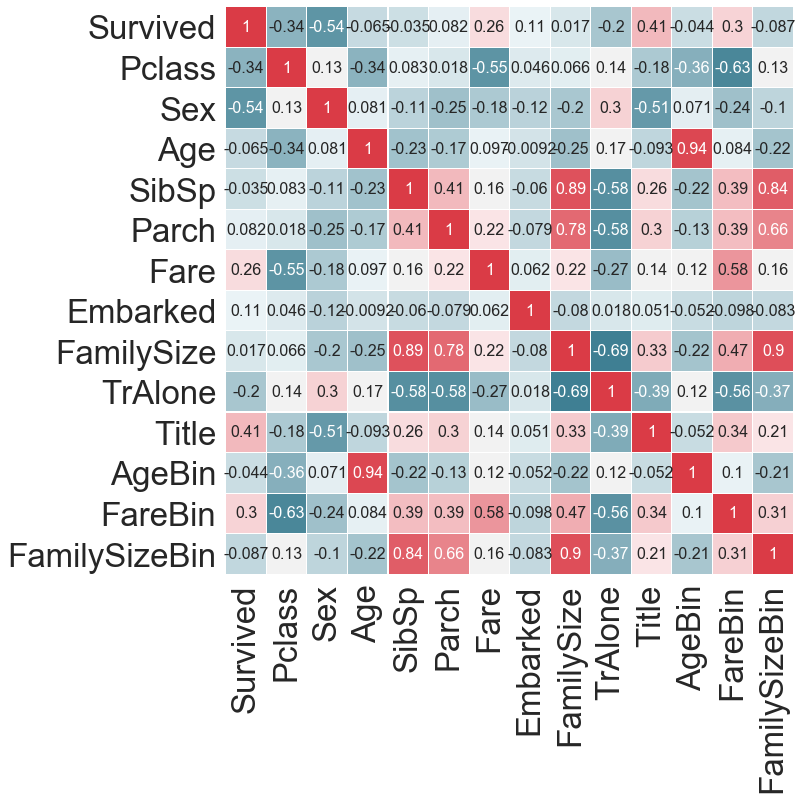

<Figure size 864x576 with 0 Axes>

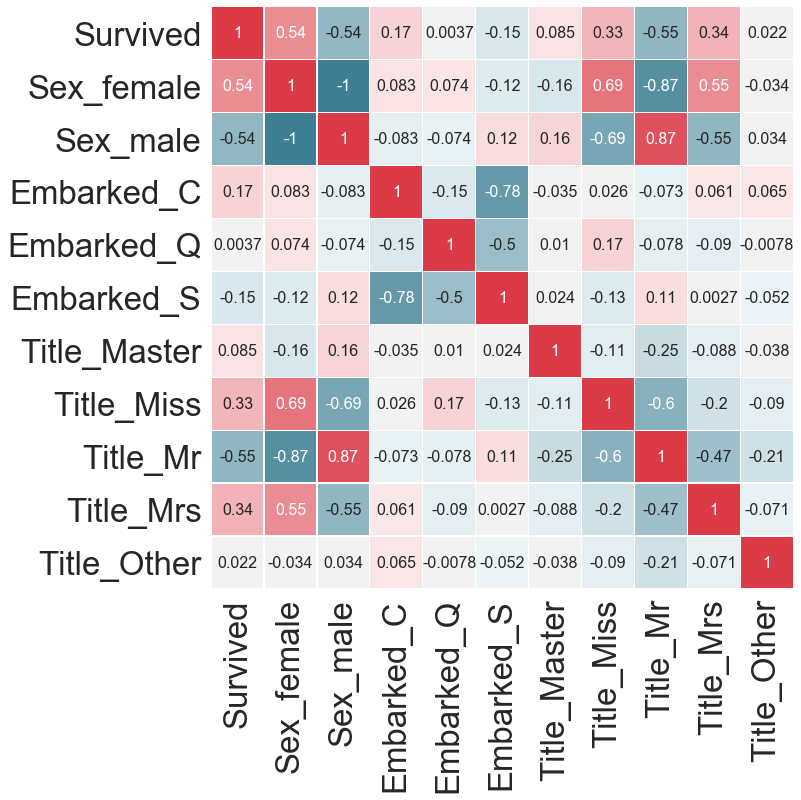

In [9]:
correlation_heatmap(df_train[df_train.columns[df_train.columns!='PassengerId']])
df = pd.concat([df_train[['Survived']], df_train_dummy], axis=1)
correlation_heatmap(df)

## Classifier comparison

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [11]:
def check_classifiers(train, classifiers):
    c_log_cols = ['Classifier', 'Accuracy']
    c_log      = pd.DataFrame(columns=c_log_cols)

    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

    X = train[0::, 1::]
    y = train[0::, 0]
    
    acc_dict = {}

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        t = time.time()
        for clf in classifiers:
            name = clf.__class__.__name__
            clf.fit(X_train, y_train)
            train_predictions = clf.predict(X_test)
            acc = accuracy_score(y_test, train_predictions)
            if name in acc_dict:
                acc_dict[name] += acc
            else:
                acc_dict[name] = acc
        elapsed_time = time.time() - t

    for clf in acc_dict:
        acc_dict[clf] = acc_dict[clf] / 10.0
        c_log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=c_log_cols)
        c_log = c_log.append(c_log_entry)

    print('Done!\nTime elapsed {}'.format(elapsed_time))
    return c_log

def plot_classifiers_results(c_log):
    plt.xlabel('Accuracy')
    plt.title('Classifier Accuracy')

    sns.set_color_codes("muted")
    sns.barplot(x='Accuracy', y='Classifier', data=c_log, color="b")
    plt.show()
    sns.scatterplot(x='Accuracy', y='Classifier', data=c_log, color="b")
    plt.show()
    print(c_log)

In [12]:
# Feature selection for the simple model
m2_features = ['Survived','Sex','Fare']
df_train_m2 = df_train[m2_features]

# Classifiers to use
m2_classifiers = [SVC(probability=True),
               DecisionTreeClassifier(),
               GaussianNB(),
               LogisticRegression()]

c_log_m2 = check_classifiers(df_train_m2.values, m2_classifiers)
print(c_log_m2)

Done!
Time elapsed 0.10937190055847168
               Classifier  Accuracy
0                     SVC  0.651111
0  DecisionTreeClassifier  0.826667
0              GaussianNB  0.780000
0      LogisticRegression  0.780000


In [13]:
candidate_classifier = DecisionTreeClassifier()
train = df_train_m2.values
test  = df_test[m2_features[1:]].values
X = train[0::, 1::]
y = train[0::, 0]
candidate_classifier.fit(X,y)
result = candidate_classifier.predict(test)

print(classification_report(candidate_classifier.predict(X), y,
                            target_names=['died', 'survived']))

              precision    recall  f1-score   support

        died       0.96      0.89      0.92       596
    survived       0.80      0.93      0.86       295

    accuracy                           0.90       891
   macro avg       0.88      0.91      0.89       891
weighted avg       0.91      0.90      0.90       891



In [14]:
submission = pd.DataFrame()
submission['PassengerId'] = df_test['PassengerId']
submission['Survived']    = result.astype(int)
submission.info()
submission.to_csv('gender_fare_SVC_submission.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int32
dtypes: int32(1), int64(1)
memory usage: 5.0 KB
